In [1]:
import os
import sys
import pandas as pd
import numpy as np

In [2]:
import funcs
from funcs import fix_ttype_feature

In [3]:
import matplotlib.pyplot as plt

In [4]:
#trainPlusTestSize = 2500
GZ1 = pd.read_csv('data/GalaxyZoo1/GZ1.csv') #Galaxy zoo data from data.galaxyzoo.org (unwanted columns removed)
features = pd.read_csv('data/features/features.csv') 
                #from sciencedirect.com/science/article/pii/S2213133719300757 (unwanted columns removed)
features = features.rename(columns={'dr7objid':'OBJID'})
features = features.drop_duplicates()
df = pd.merge(features, GZ1, on='OBJID', how='inner')
df = df[df.UNCERTAIN==0].drop(columns=['UNCERTAIN']) #remove Uncertain category, i.e. not elliptical nor spiral
df = df[df.Error==0] #Keep successful CyMorph processes only. See kaggle.com/datasets/saurabhshahane/galaxy-classification
df = df[(df['G2']>-6000) & (df['S']>-6000) & (df['A']>-6000) & (df['C']>-6000)] #discard outliers
df = df.drop(['Error'], axis=1) 
df = fix_ttype_feature(df)
#df = df.sample(n=trainPlusTestSize, random_state=1)
df = df.reset_index(drop=True)

/tmp/ipykernel_32448/176806989.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv('data/features/features.csv')


In [5]:
df

,OBJID,TType,K,C,A,S,G2,H,SPIRAL,ELLIPTICAL
0,587722952230175035,3.324519,13.578409,0.329970,0.773113,0.845577,1.741071,0.828695,1,0
1,587722952230175145,1.808333,16.767047,0.322301,0.861787,0.934300,1.511484,0.740404,1,0
2,587722952230175173,2.634476,23.491833,0.338940,0.777340,0.881642,1.539079,0.740161,1,0
3,587722952230240617,3.080550,35.769025,0.330124,0.762131,0.910175,1.102738,0.654903,1,0
4,587722952230306064,3.474909,19.064729,0.357764,0.752091,0.786814,1.791984,0.856504,1,0
...,...,...,...,...,...,...,...,...,...,...
215627,588848901536612515,3.276491,19.212198,0.334808,0.709664,0.833637,1.628970,0.764711,1,0
215628,588848901537005642,-1.925249,11.476779,0.414721,0.910051,0.779990,1.233172,0.630266,0,1
215629,588848901537202306,-1.726022,6.435532,0.458886,0.926424,0.886835,1.451324,0.663563,0,1
215630,588848901538578615,-0.348994,11.534325,0.375858,0.885514,0.823752,1.398682,0.659621,1,0


# Distributions

In [6]:
def features_grouped_by_label(df, features=['K', 'C', 'A', 'S', 'G2', 'H'], extra_title=''):    
    bins=100
    fig, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(5, 5*len(features)))
    
    # loop through each feature column and create a histogram for each label
    for i, feature in enumerate(features):
        axs[i].hist(df[df['SPIRAL']==1][feature], bins, density=True, histtype=u'step', label='spiral')
        axs[i].hist(df[df['ELLIPTICAL']==1][feature], bins, density=True, histtype=u'step', label='elliptical')
        #axs[i].hist(df[df['UNCERTAIN']==1][feature], bins, histtype=u'step', label='uncertain')
        axs[i].set_title('feature='+feature + extra_title)
        axs[i].legend(loc='upper center',bbox_to_anchor=(0, 0, 1, 1))
    plt.show()

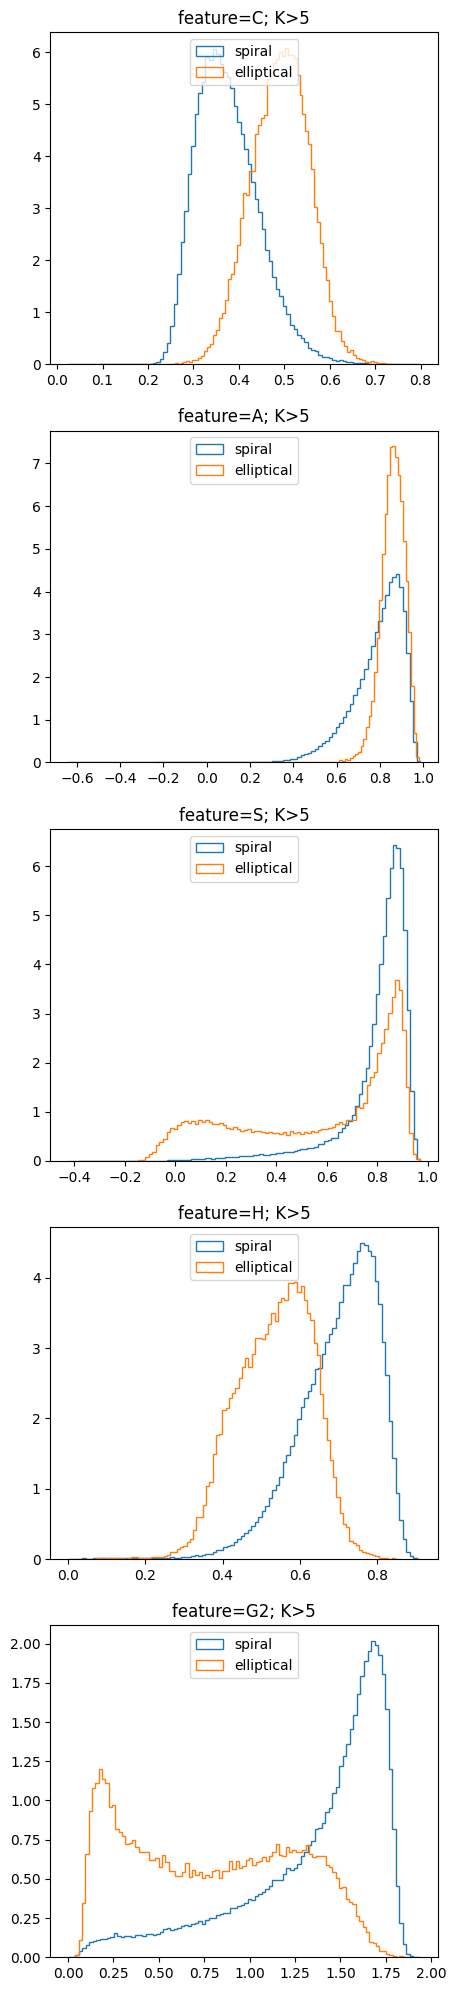

In [7]:
features_grouped_by_label(df[df['K']>5], features=['C', 'A', 'S', 'H', 'G2'], extra_title='; K>5')


# PCA

In [8]:
train_data, train_labels, test_data, test_labels, train_extraInfo, test_extraInfo = funcs.get_train_test(df, n_splits=5, fold_idx=0)


In [9]:
train_data = funcs.normalize_data(train_data)
test_data = funcs.normalize_data(test_data)

In [10]:
n_features = np.shape(train_data)[1]

In [11]:
from sklearn.decomposition import PCA

# Perform PCA on the features
pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_data)

In [12]:
train_labels.iloc[:1000]

0       1
2       1
5       1
6       1
7       1
       ..
1225    1
1226    1
1227    1
1232    1
1233    1
Name: SPIRAL, Length: 1000, dtype: int64

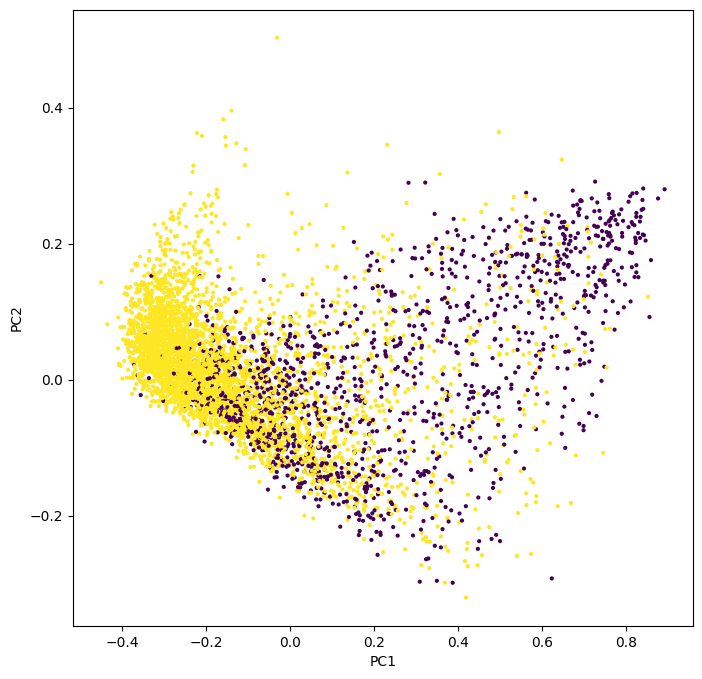

In [13]:
# Plot the two most important features, color-coded by their labels
nDataPointsToPlot = 5000
fig = plt.figure(figsize=(8, 8))
#colors = ['red' if l == 0 else 'blue' for l in train_labels]
plt.scatter(pca_features[:nDataPointsToPlot,0], pca_features[:nDataPointsToPlot,1], c=train_labels.iloc[:nDataPointsToPlot], s=4, alpha=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
#plt.legend(['spiral', 'elliptical'], loc='upper right')
plt.show()
